In [1]:
import pandas as pd
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

deg_to_rad = np.pi/180

In [2]:
df = pd.read_csv("cell_metrics_VISp.csv")

In [3]:
id_cols = [
    "experiment_container_id", "cell_specimen_id"
]

sg_cols = [
    "pref_ori_sg", "pref_sf_sg", "pref_phase_sg"
]

dg_cols = [
    "pref_dir_dg", "pref_tf_dg"
]

In [4]:
df = df[df["failed_experiment_container"]=="f"]
len(df)

63251

### Sample Image

In [5]:
im = cv2.imread("sample_image.jpeg")

In [6]:
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

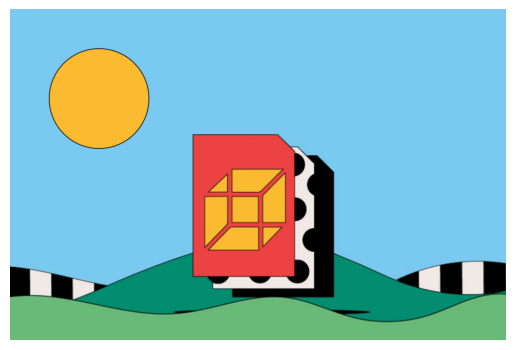

In [7]:
ax = plt.imshow(im[:,:,::-1])
plt.axis('off')
plt.show()

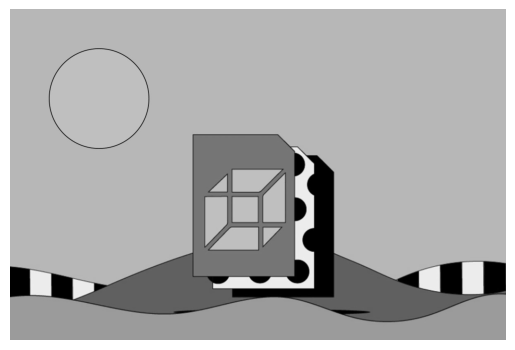

In [8]:
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.show()

### Sample Static Filters

In [9]:
df_sg = df[id_cols+sg_cols].dropna()

len(df_sg)

30997

In [10]:
df_sg[df_sg.pref_phase_sg==0]

,experiment_container_id,cell_specimen_id,pref_ori_sg,pref_sf_sg,pref_phase_sg
8,511498742,517397369,30.0,0.08,0.0
10,511498742,517397377,30.0,0.08,0.0
16,511498742,517397407,60.0,0.02,0.0
29,511498742,517397509,0.0,0.32,0.0
35,511498742,517397564,60.0,0.16,0.0
...,...,...,...,...,...
63217,712178509,738948099,0.0,0.08,0.0
63223,712178509,738948306,150.0,0.32,0.0
63230,712178509,738948535,60.0,0.08,0.0
63231,712178509,738948566,150.0,0.04,0.0


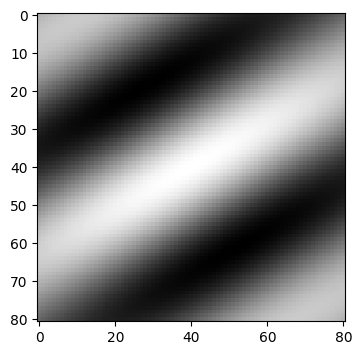

In [11]:
ori = 60
sf = 0.02
phase = 0

g = cv2.getGaborKernel(
    ksize=(80,80),
    sigma=1/sf, # 50
    theta=ori*deg_to_rad,
    lambd=1/sf,
    gamma=1, # 1
    psi=phase*2*np.pi, 
)

plt.figure(figsize=(5, 4))
plt.imshow(g, cmap='gray')
plt.show()

In [12]:
im_conv = cv2.filter2D(
    im_gray,
    ddepth=cv2.CV_32F,
    kernel=cv2.flip(g,-1),
    borderType=cv2.BORDER_CONSTANT
)

In [13]:
def convolution2d(image, kernel, padding=None):
    kernel = cv2.flip(kernel,-1)
    m, _ = kernel.shape
    
    if padding is not None:
        p = int(np.floor(m/2))
        image_pad = cv2.copyMakeBorder(
            image,
            top=p,
            bottom=p,
            left=p,
            right=p,
            borderType=cv2.BORDER_CONSTANT,
            value=padding,
        )
        print(f"Image dimensions changed from {image.shape} to {image_pad.shape}")
    else:
        image_pad = image
    
    y, x = image_pad.shape
    y = y - m + 1
    x = x - m + 1
    new_image = np.zeros((y,x))
    for i in range(y):
        for j in range(x):
            new_image[i][j] = np.sum(image_pad[i:i+m, j:j+m]*kernel)
    return new_image

im_conv2 = convolution2d(im_gray, g, padding=0)

Image dimensions changed from (800, 1200) to (880, 1280)


In [14]:
im_conv_norm = (510*(im_conv - im_conv.min())/(im_conv.max() - im_conv.min()) -255).astype(np.int32)

In [15]:
im_conv_clip = im_conv.copy()
im_conv_clip[im_conv_clip<0] = 0
im_conv_clip[im_conv_clip>255] = 255

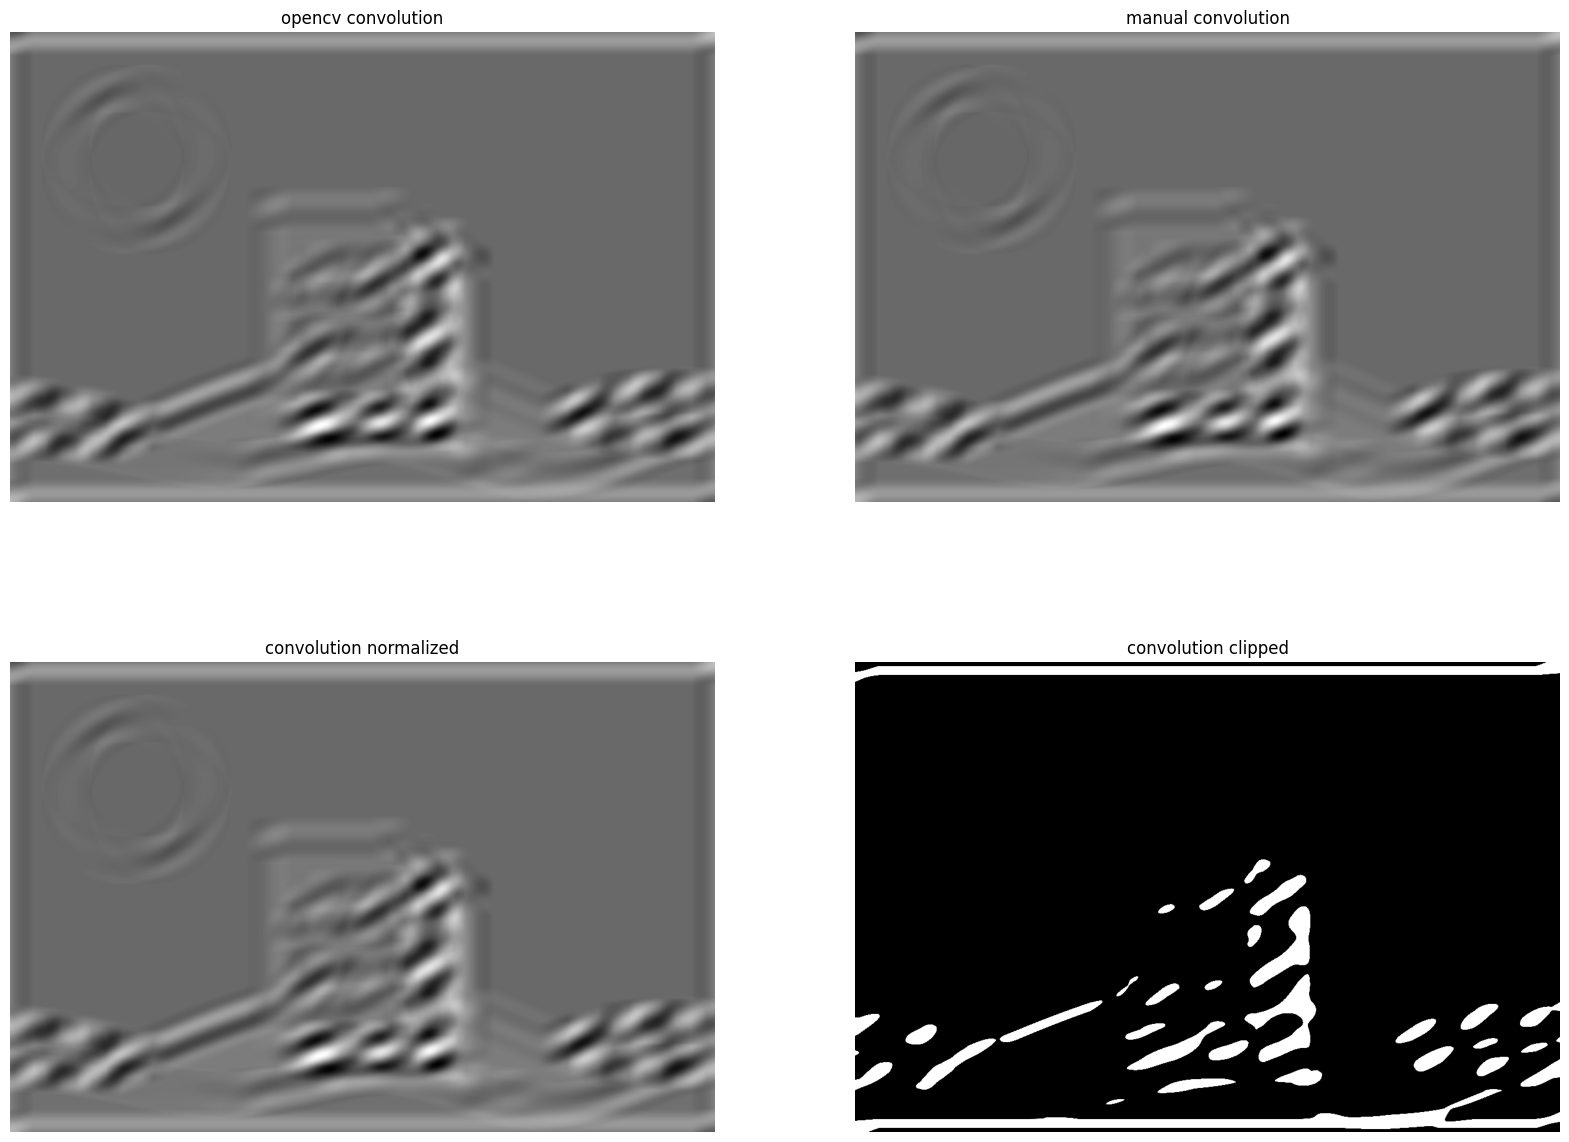

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax[0,0].axis('off')
ax[0,0].set_title("opencv convolution")
ax[0,0].imshow(im_conv, cmap='gray')

ax[0,1].axis('off')
ax[0,1].set_title("manual convolution")
ax[0,1].imshow(im_conv2, cmap='gray')

ax[1,0].axis('off')
ax[1,0].set_title("convolution normalized")
ax[1,0].imshow(im_conv_norm, cmap='gray')

ax[1,1].axis('off')
ax[1,1].set_title("convolution clipped")
ax[1,1].imshow(im_conv_clip, cmap='gray')

plt.show()

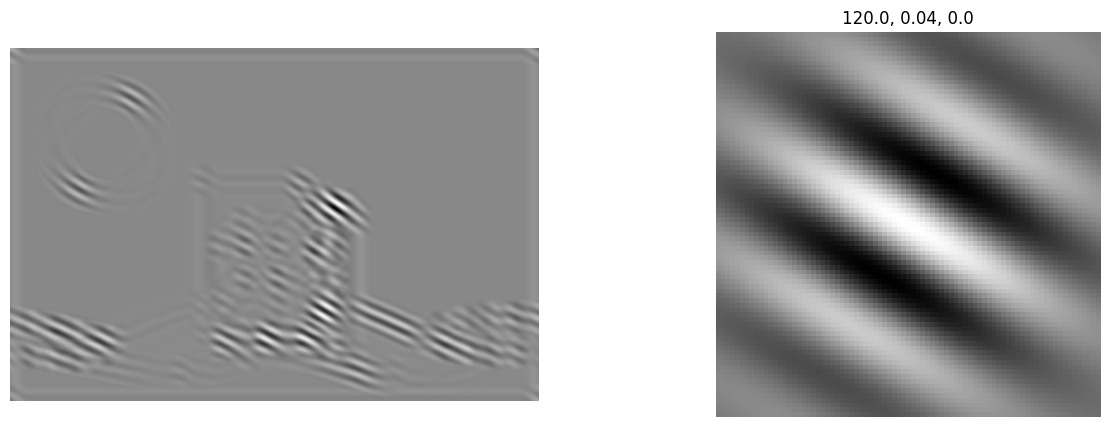

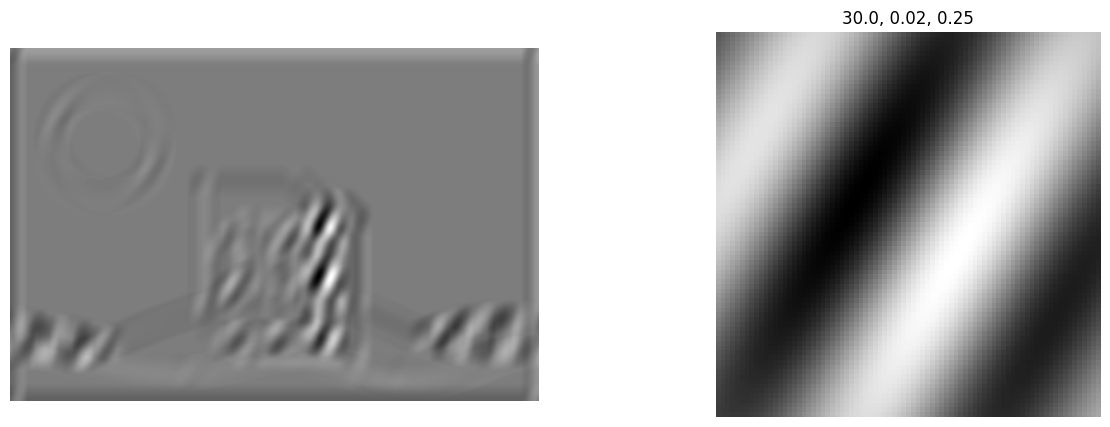

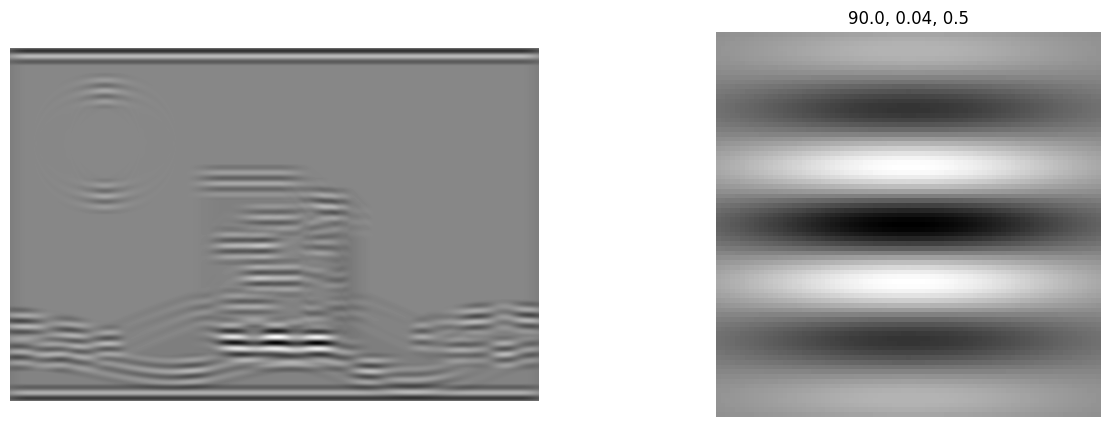

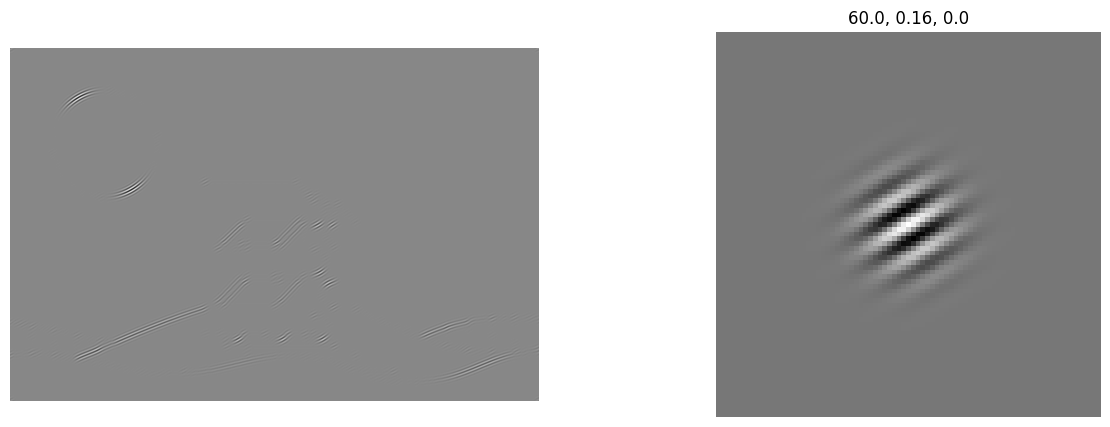

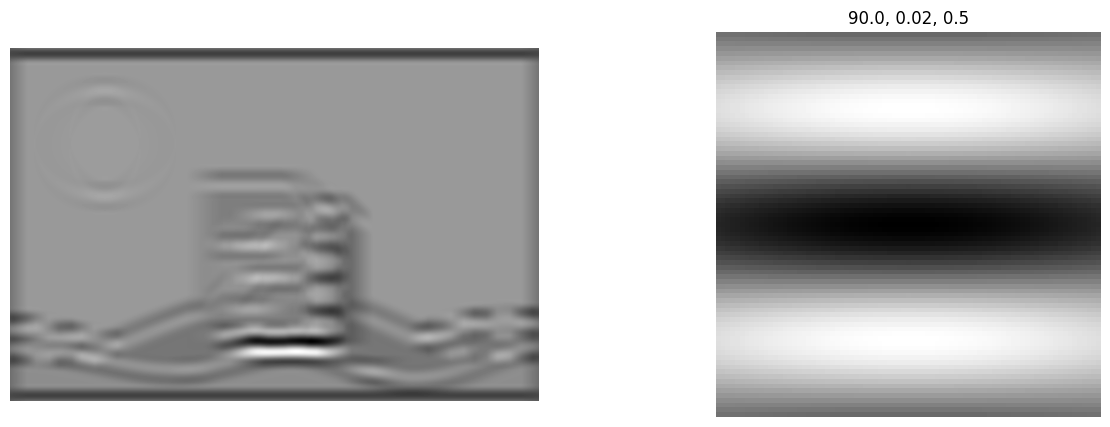

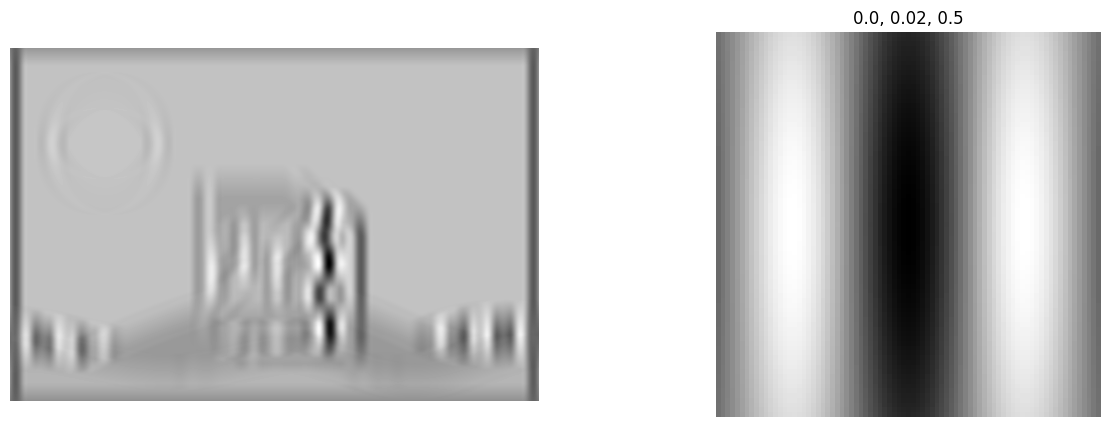

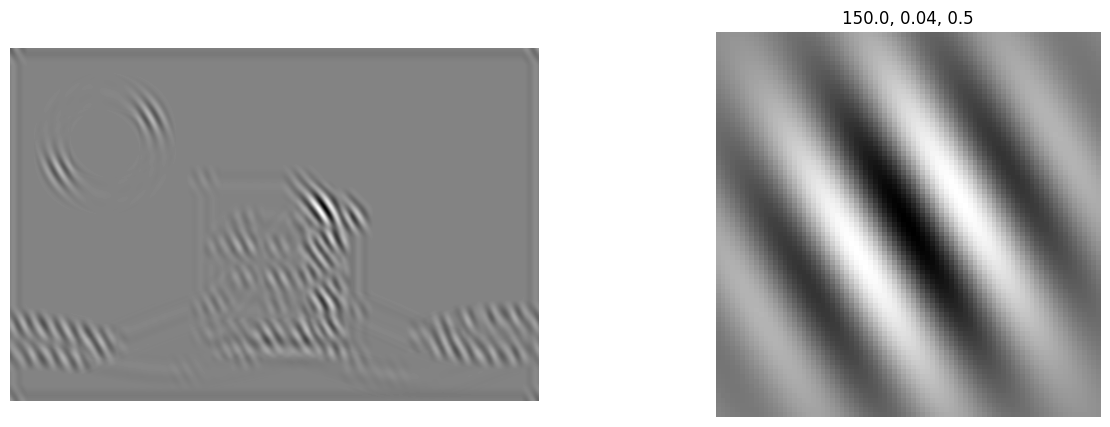

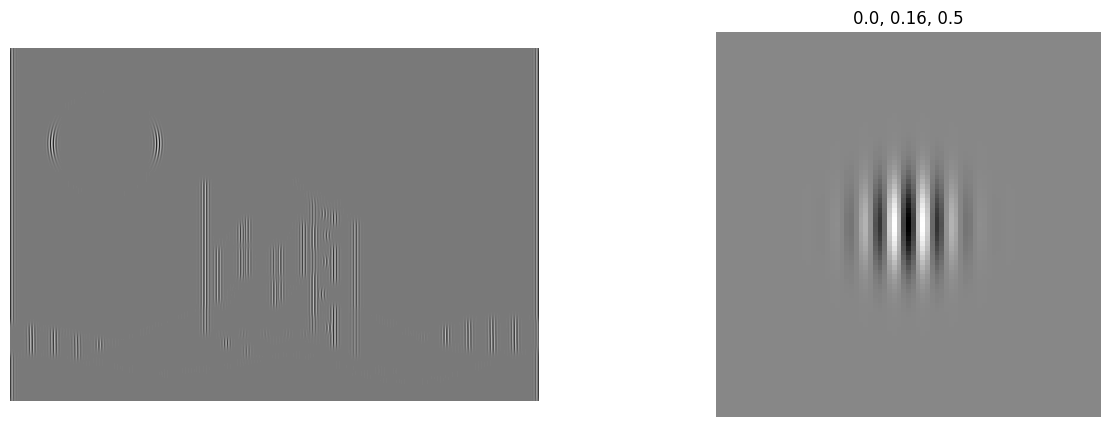

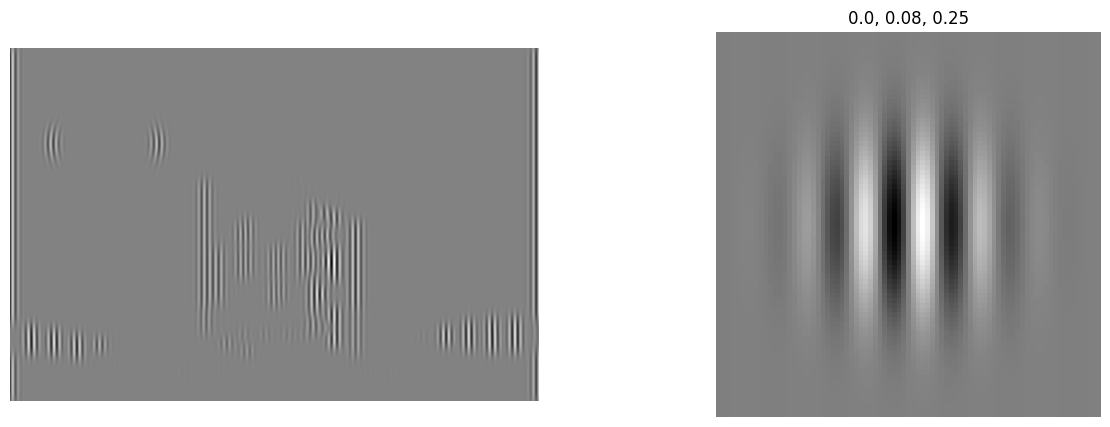

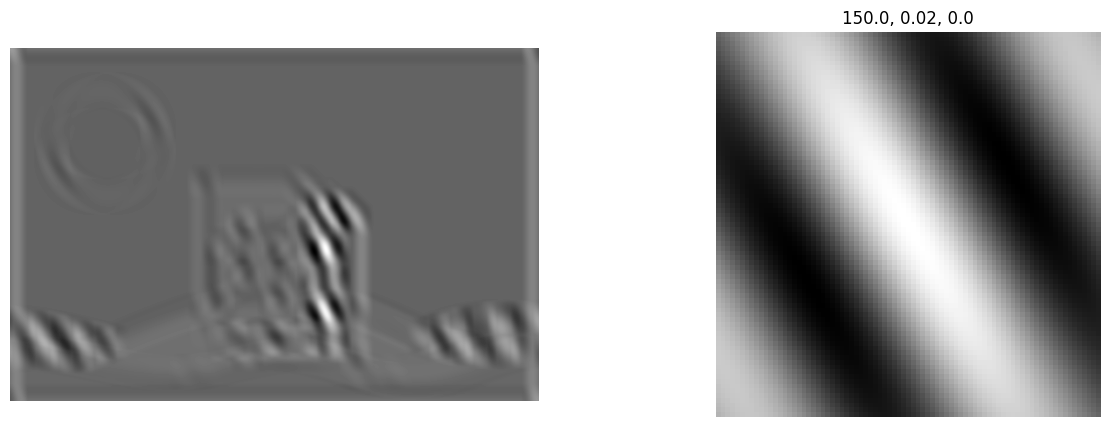

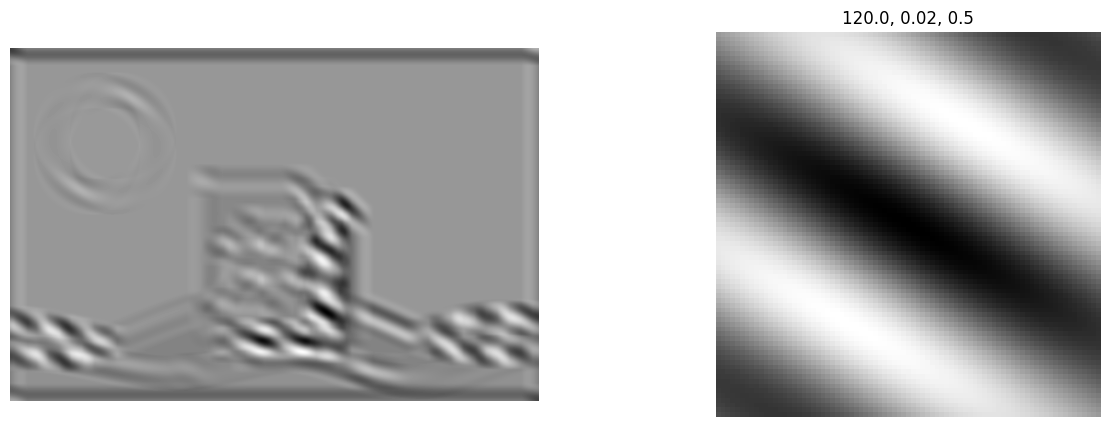

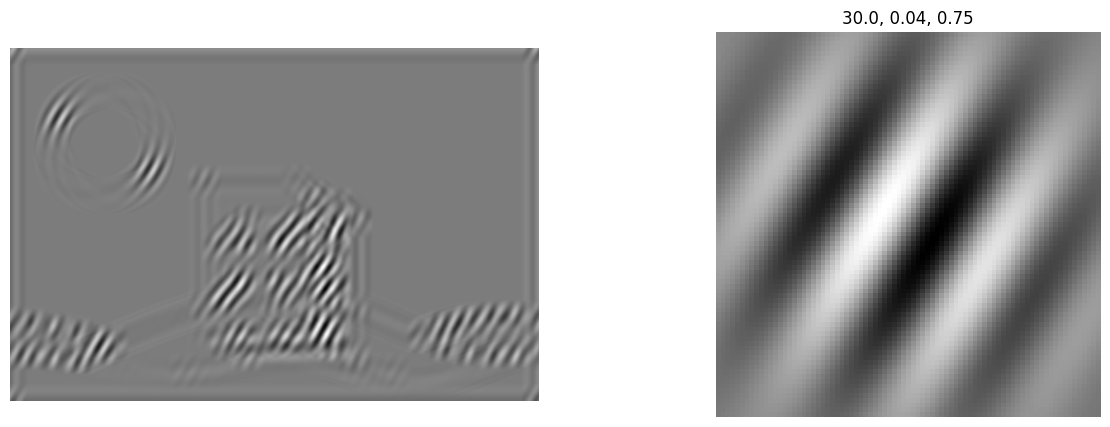

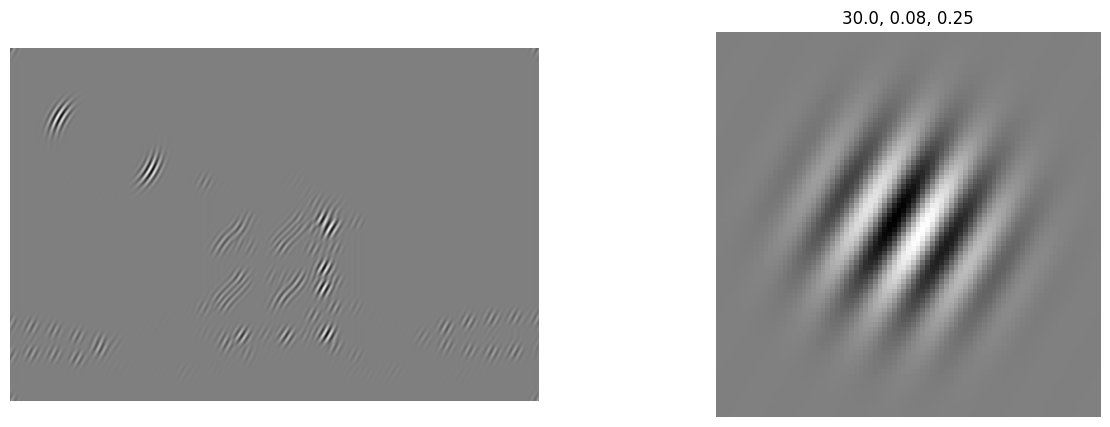

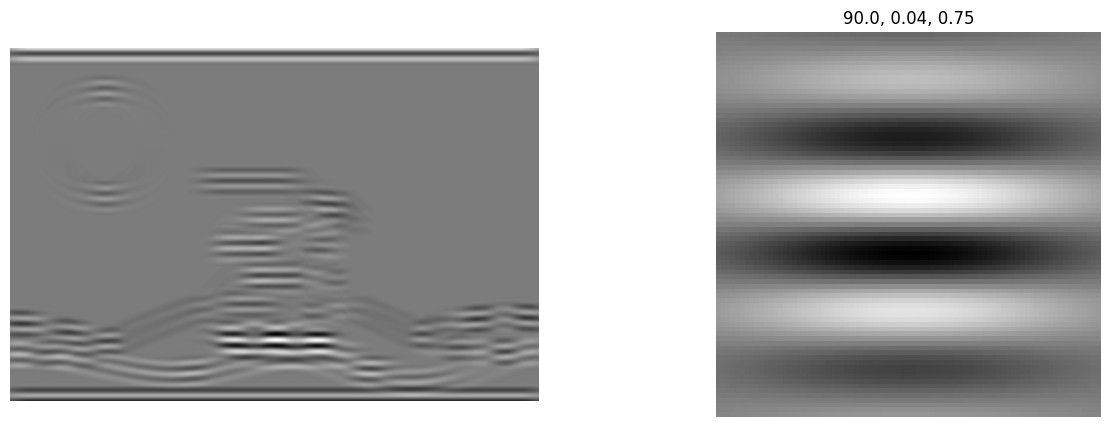

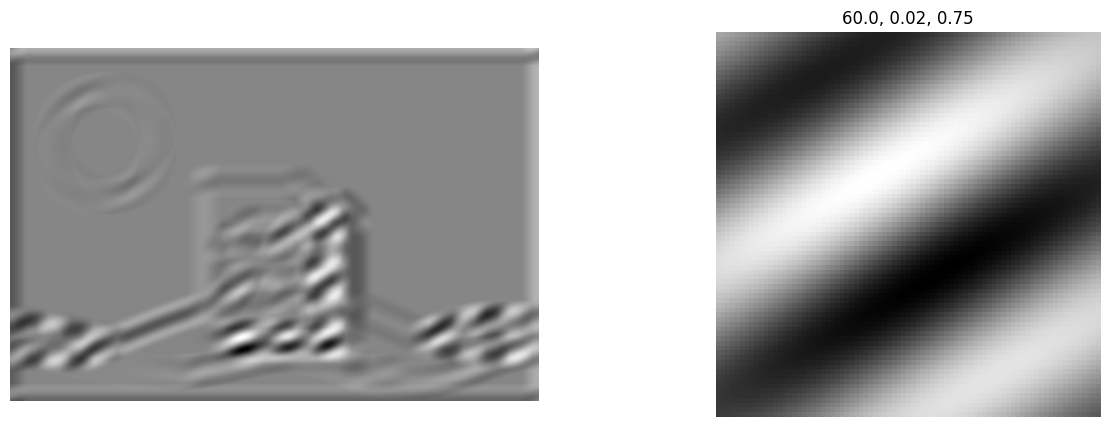

In [23]:
for _, r in df_sg.sample(15).iterrows():
    ori = r['pref_ori_sg']
    sf = r['pref_sf_sg']
    phase = r['pref_phase_sg']
    
    g = cv2.getGaborKernel(
        ksize=(80,80),
        sigma=1/sf, # 50
        theta=ori*deg_to_rad,
        lambd=1/sf,
        gamma=1, # 1
        psi=phase*2*np.pi, 
    )
    
    im_conv = cv2.filter2D(
        im_gray,
        ddepth=cv2.CV_32F,
        kernel=cv2.flip(g,-1),
        borderType=cv2.BORDER_CONSTANT
    )

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].imshow(im_conv, cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(g, cmap='gray')
    ax[1].axis('off')
    
    plt.title(f"{ori}, {sf}, {phase}")
    plt.axis('off')
    plt.show()

### Sample Dynamic Filters

In [19]:
df_dg = df[id_cols+dg_cols].dropna()

len(df_dg)

29635

In [20]:
frames_per_s = 60

In [21]:
spat_freq = 0.08
temp_freq = 4
orientation = 0 # true values are 0, 45, 90, 135, 180, 225, 270, 315

In [22]:
gs = [
    cv2.getGaborKernel(
        ksize=(80,80),
        sigma=40,
        theta=orientation*deg_to_rad,
        lambd=1/spat_freq,
        gamma=1,
        psi=i*2*np.pi,
    )
    for i in np.linspace(0, 1, int(frames_per_s/temp_freq))
]